In [1]:
import pandas as pd
from bs4 import BeautifulSoup             
import re
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv("labeledTrainData.tsv", header=0, \
                    delimiter="\t", quoting=3)
train = train.drop(['id'], axis=1)
train.head()

,sentiment,review
0,1,"""With all this stuff going down at the moment ..."
1,1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,0,"""The film starts with a manager (Nicholas Bell..."
3,0,"""It must be assumed that those who praised thi..."
4,1,"""Superbly trashy and wondrously unpretentious ..."


In [3]:
def review_to_words( raw_review ):
    # the output is a single string (a preprocessed movie review)

    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review,).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

**Creating Features from a Bag of Words (Using scikit-learn)**

In [4]:
# Get the number of reviews based on the dataframe column size
num_reviews = train["review"].size

# Initialize an empty list to hold the clean reviews
clean_train_reviews = []

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
print ("Cleaning and parsing the training set movie reviews...\n")
clean_train_reviews = []
for i in range( 0, num_reviews ):
    # If the index is evenly divisible by 10000, print a message
    if( (i+1)%10000 == 0 ):
        print ("Review %d of %d\n" % ( i+1, num_reviews ))                                                                 
    clean_train_reviews.append( review_to_words( train["review"][i] ))
print("Done")

Cleaning and parsing the training set movie reviews...

Review 10000 of 25000

Review 20000 of 25000

Done


In [5]:
print ("Creating the bag of words...\n")
from sklearn.feature_extraction.text import CountVectorizer

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000) 

# The input to fit_transform should be a list of strings.
train_data_features = vectorizer.fit_transform(clean_train_reviews)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features.toarray()
print ("Done")


Creating the bag of words...

Done


**Creating a WordCloud**

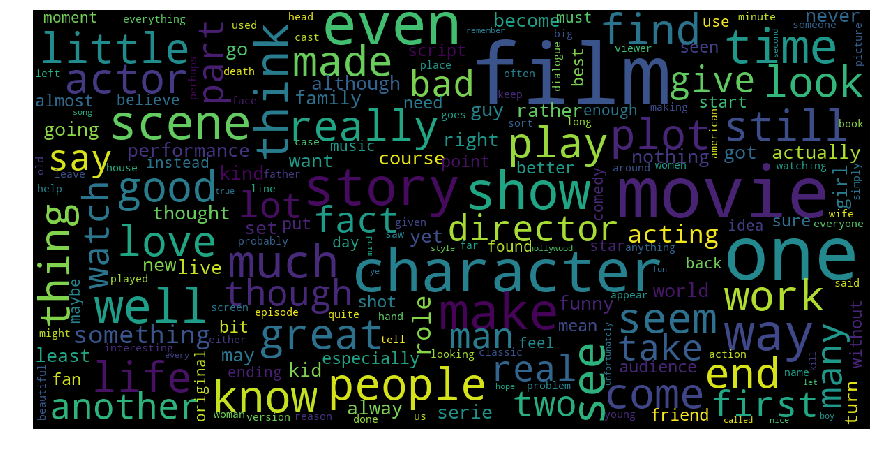

In [6]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(clean_train_reviews)

In [7]:
#splitting dataset into training and testing data
from sklearn.model_selection import train_test_split
x_train, x_train_pred, y_train, y_train_pred = train_test_split(train_data_features,train["sentiment"],test_size=0.2,random_state=0)
print("Splitting Done")

Splitting Done


In [8]:
print ("Training the random forest model...")
from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as 
# features and the sentiment labels as the response variable

# This may take a few minutes to run
forest = forest.fit(x_train, y_train )
print ("Done")


Training the random forest model...
Done


In [9]:
# Use the random forest to make sentiment label predictions
result = forest.predict(x_train_pred)
print("Predictions Done")

Predictions Done


In [10]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

#checking accuracy score
accuracy = accuracy_score(y_train_pred,result)
accuracy

0.851

In [19]:
train_result=forest.predict(x_train)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [25]:
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16
LARGE_SIZE = 20

params = {
    'figure.figsize': (16, 8),
    'font.size': SMALL_SIZE,
    'xtick.labelsize': MEDIUM_SIZE,
    'ytick.labelsize': MEDIUM_SIZE,
    'legend.fontsize': BIG_SIZE,
    'figure.titlesize': LARGE_SIZE,
    'axes.titlesize': MEDIUM_SIZE,
    'axes.labelsize': BIG_SIZE
}
plt.rcParams.update(params)

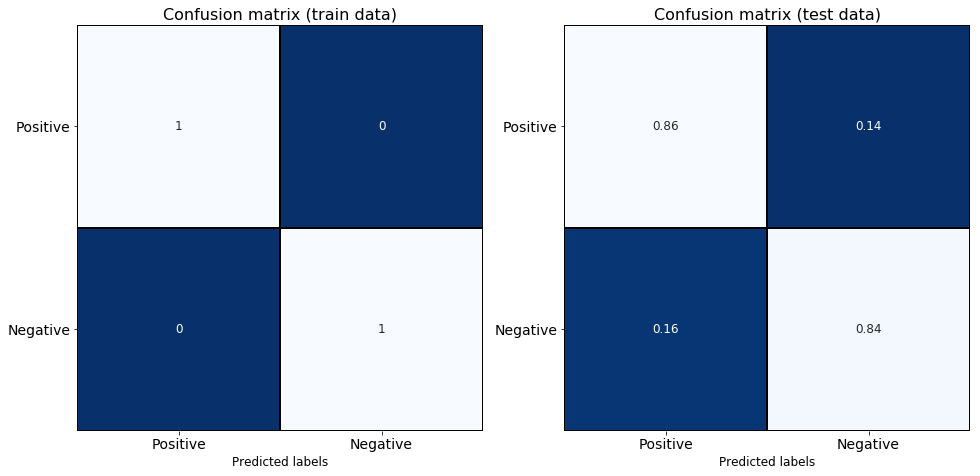

In [28]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, train_result, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_train_pred, result, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

In [31]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix

f1=f1_score(y_train_pred, result)
print("F1 Score:")
print(f1)

F1 Score:
0.8473673427576316
